In [15]:
#! /usr/bin/env python
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import pylab

In [2]:
df = pd.read_csv('./output/GoodMockGPQNIR_encap_10.csv')
df_declim = df[df.dec>-30]
c = SkyCoord(df.l.values * u.deg, df.b.values * u.deg, frame='galactic')
newl = c.l.wrap_at(180 * u.deg)

<ipython-input-3-58bb5242f68f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_declim['pix'] = ahp.skycoord_to_healpix(coord)


The area per pix is 0.839 deg^2 and the highest density per pix is 134.637


80.00000000000003 99.99999999999997 -9.999999999999975 9.999999999999975


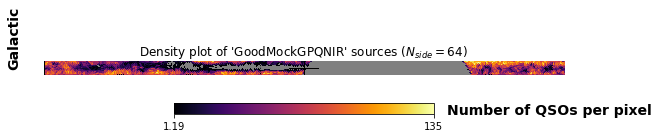

In [3]:
# coord = SkyCoord(ra=df['ra'].values * u.degree,
#                  dec=df['dec'].values * u.degree, frame='icrs')
# cgal = coord.transform_to(frame='galactic')

# nside	= 2**res	: The number of pixels per side.
# npix	= 12*nside**2	: The total number of pixels in the map.

nside = 64
coord = SkyCoord(l=df_declim['l'].values * u.degree,
                 b=df_declim['b'].values * u.degree, frame='galactic')
ahp = HEALPix(nside=nside, order='ring', frame=Galactic())
df_declim['pix'] = ahp.skycoord_to_healpix(coord)
hptb = df_declim.groupby('pix').size()
npix = hp.nside2npix(nside)

pi = np.pi
ssky = 4 * pi * ((180 / pi)**2)
spix = ssky / npix
sig_max = hptb.max() / (ssky / npix)
print('The area per pix is {0:.3f} deg^2 and the highest density per\
 pix is {1:.3f}'.format(spix, sig_max))

hpxmap = np.zeros(npix, dtype=float)
for i in hptb.index.values:
    hpxmap[i] = hptb[i]  # 只填充有值的位置
hpxmap = hpxmap/spix
hpxmap[hpxmap <= 0] = hp.pixelfunc.UNSEEN
# hpxmap_sm = hp.smoothing(hpxmap,fwhm=np.radians(1))

cartb = hp.cartview(hpxmap,
                    coord=["G"],
                    # latra=[-20,20],
                    latra = [-5,5],  # 限制正负五度天区
                    cmap='inferno',
#             badcolor='w',
#             bgcolor='w',
                    unit="Number of QSOs per pixel",
                    xsize=1800, 
                    return_projected_map=True,
                   title="Density plot of 'GoodMockGPQNIR' sources ($N_{side}=64$)")



map_dump = pd.DataFrame(cartb)
map_dump.to_csv('hpsm_GoodMockGPQNIR_b5_bootstrap.csv',index=None)

hp.graticule()
f = plt.gcf()
# f.savefig('densMockGPQ.pdf')




iring = np.arange(npix)
inest = hp.ring2nest(nside, iring)
# hp.write_map('MockGPQ_healpixmap.fits',
#              m=[iring, inest, hpxmap],
#              coord='G',
#              column_names=['iring', 'inest', 'map'],
#              fits_IDL=False,
#              overwrite=True)

In [4]:
df_cmgpq_b5_b = pd.read_csv('hpsm_GoodMockGPQNIR_b5_bootstrap.csv',index_col=False)
cmgpq_b5_b = df_cmgpq_b5_b.values

# df_cmgpq_b5_r = pd.read_csv('hpsm_GoodMockGPQNIR_b5_recycling.csv',index_col=False)
# cmgpq_b5_r = df_cmgpq_b5_r.values

# df_cmgpq_b20 = pd.read_csv('hpsm_GoodMockGPQ_b20.csv',index_col=False)
# # 选取b为正负5度的数据：index为75-124 
# df1 = df_cmgpq_b20.loc[[i for i in range(75,125,1)]]
# cmgpq_b20 = df1.values

## 1. b5 GoodMockGPQ sky density

In [8]:
df_minmaxmedian = pd.DataFrame(
    [[np.nanmin(cmgpq_b20),np.nanmax(cmgpq_b20),np.nanmedian(cmgpq_b20)],
     [np.nanmin(cmgpq_b5_r),np.nanmax(cmgpq_b5_r),np.nanmedian(cmgpq_b5_r)],
    [np.nanmin(cmgpq_b5_b),np.nanmax(cmgpq_b5_b),np.nanmedian(cmgpq_b5_b)]],
        index = ['b20','b5_r','b5_b'],columns=['min','max','median'])

df_minmaxmedian

,min,max,median
b20,1.191478,22.638084,4.765912
b5_r,1.191478,64.339818,25.021040
b5_b,1.191478,126.296679,59.573905


In [7]:
cmgpq_b5_b.shape

(50, 1800)

# 2. plot sky density

In [13]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE, family='serif')    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# plt.rc('font', family='serif')    # controls default text sizes
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

# plt.rcParams["figure.figsize"] = (10,4) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 250 # 提高图片分辨率

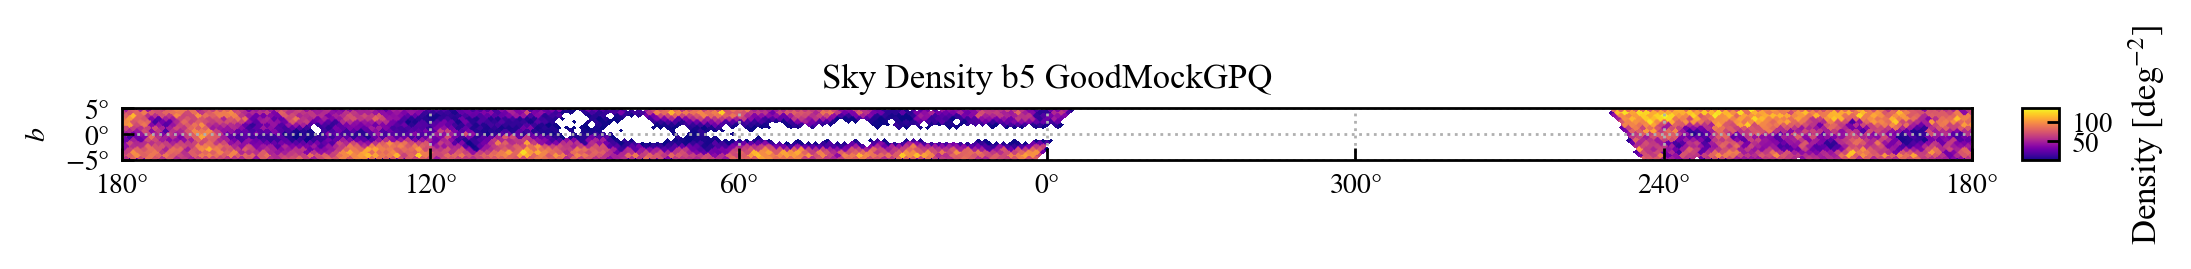

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, (ax1) = plt.subplots(nrows=1, figsize=(10,3))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='2%', pad=0.2)
im = ax1.imshow(cmgpq_b5_b.data,
                origin='lower',
                cmap='plasma',
#                 norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq))
               )
ax1.set_xticks(np.arange(0, 1801, 300))
ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                      r'$0\degree$',r'$300\degree$',r'$240\degree$',
                      r'$180\degree$'))
ax1.set_yticks(np.arange(0, 51, 25))
ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax1.set_ylabel(r"$b$")
ax1.grid(linestyle=':')
cbar1 = fig.colorbar(im, cax=cax, 
                     orientation='vertical',
                     label='Density [$\mathrm{deg}^{-2}$]')
cbar1.ax.yaxis.label.set_size(10)
ax1.title.set_text('Sky Density b5 GoodMockGPQ')


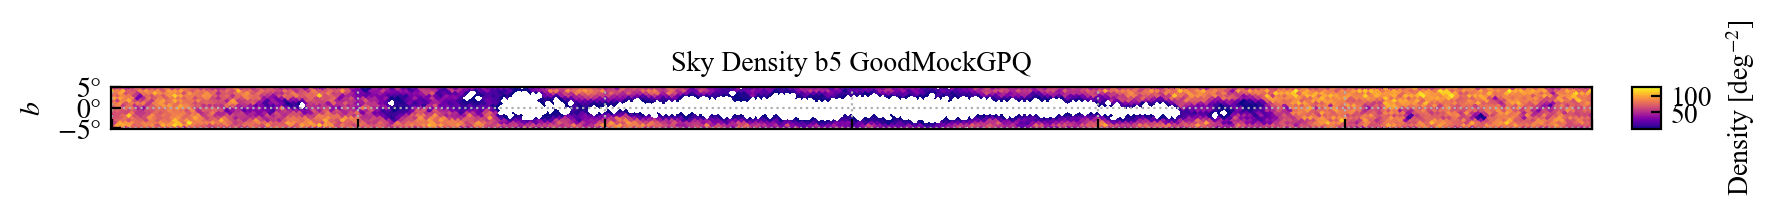

In [10]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import LogNorm
# fig, (ax1) = plt.subplots(nrows=1, figsize=(10,3))
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='2%', pad=0.2)
# im = ax1.imshow(cmgpq_b5_b.data,
#                 origin='lower',
#                 cmap='plasma',
# #                 norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq))
#                )
# ax1.set_xticks(np.arange(0, 1801, 300))
# ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
#                       r'$0\degree$',r'$300\degree$',r'$240\degree$',
#                       r'$180\degree$'))
# ax1.set_xticklabels([])
# ax1.set_yticks(np.arange(0, 51, 25))
# ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
# ax1.set_ylabel(r"$b$")
# ax1.grid(linestyle=':')
# cbar1 = fig.colorbar(im, cax=cax, 
#                      orientation='vertical',
#                      label='Density [$\mathrm{deg}^{-2}$]')
# cbar1.ax.yaxis.label.set_size(10)
# ax1.title.set_text('Sky Density b5 GoodMockGPQ')

b5_recycling mocking：
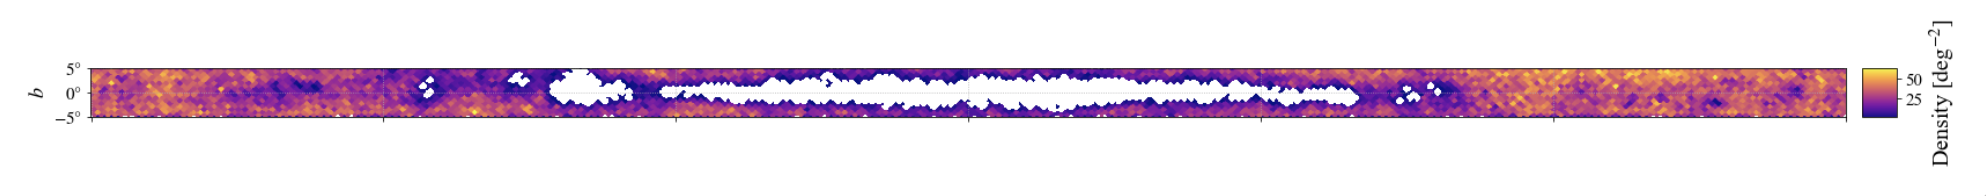

'\nim3 = ax3.imshow(cmgpq_b5_b.data,\n                origin=\'lower\',\n                cmap=\'plasma\',\n               norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq_b5_b))\n               )\nax3.set_xticks(np.arange(0, 1801, 300))\nax3.set_xticklabels((r\'$180\\degree$\',r\'$120\\degree$\',r\'$60\\degree$\',\n                     r\'$0\\degree$\',r\'$300\\degree$\',r\'$240\\degree$\',\n                     r\'$180\\degree$\'))\nax3.set_xlabel(r"$l$")\nax3.set_yticks(np.arange(0, 51, 25))\nax3.set_yticklabels((r\'$-5\\degree$\',r\'$0\\degree$\',r\'$5\\degree$\'))\nax3.set_ylabel(r"$b$")\nax3.grid(linestyle=\':\')\ncbar3 = fig.colorbar(im3, \n                     cax=cax3, \n#                      shrink=0.5,\n                     orientation=\'vertical\',\n#                      label=\'Density [$\\mathrm{deg}^{-2}$]\'\n                    )\n# cbar2.ax.yaxis.label.set_size(40)\nax3.title.set_text(\'GoodMockGPQNIR_bootstrap mocking\')\n\n\n#plt.savefig("./output/GMGPQ-NIR-v0

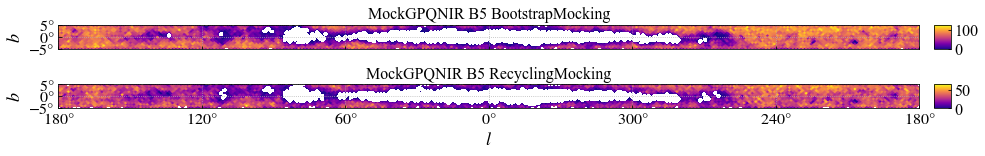

In [15]:
# plot on one figure

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(16,2))
divider1,divider2 = make_axes_locatable(ax1),make_axes_locatable(ax2)
cax1,cax2 = divider1.append_axes('right', size='2%', pad=0.2),\
                    divider2.append_axes('right', size='2%', pad=0.2),\
                        #divider3.append_axes('right', size='2%', pad=0.2)

im1 = ax1.imshow(cmgpq_b5_b.data,
                origin='lower',
                cmap='plasma',
               norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq_b5_b))
               )
ax1.set_xticks(np.arange(0, 1801, 300))
ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                    r'$0\degree$',r'$300\degree$',r'$240\degree$',
                    r'$180\degree$'))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 51, 25))
ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax1.set_ylabel(r"$b$")
ax1.grid(linestyle=':')
cbar1 = fig.colorbar(im1, cax=cax1, 
                     orientation='vertical',
#                      label='Density [$\mathrm{deg}^{-2}$]'
                    )
# cbar1.ax.yaxis.label.set_size(20)
ax1.title.set_text('MockGPQNIR B5 BootstrapMocking')
           
    
im2 = ax2.imshow(cmgpq_b5_r.data,
                origin='lower',
                cmap='plasma',
               norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq_b5_r))
               )
ax2.set_xticks(np.arange(0, 1801, 300))
ax2.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                     r'$0\degree$',r'$300\degree$',r'$240\degree$',
                     r'$180\degree$'))
ax2.set_xlabel(r"$l$")
ax2.set_yticks(np.arange(0, 51, 25))
ax2.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax2.set_ylabel(r"$b$")
ax2.grid(linestyle=':')
cbar2 = fig.colorbar(im2, 
                     cax=cax2, 
#                      shrink=0.5,
                     orientation='vertical',
#                      label='Density [$\mathrm{deg}^{-2}$]'
                    )
# cbar2.ax.yaxis.label.set_size(40)
ax2.title.set_text('MockGPQNIR B5 RecyclingMocking')

'''
im3 = ax3.imshow(cmgpq_b5_b.data,
                origin='lower',
                cmap='plasma',
               norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq_b5_b))
               )
ax3.set_xticks(np.arange(0, 1801, 300))
ax3.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                     r'$0\degree$',r'$300\degree$',r'$240\degree$',
                     r'$180\degree$'))
ax3.set_xlabel(r"$l$")
ax3.set_yticks(np.arange(0, 51, 25))
ax3.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax3.set_ylabel(r"$b$")
ax3.grid(linestyle=':')
cbar3 = fig.colorbar(im3, 
                     cax=cax3, 
#                      shrink=0.5,
                     orientation='vertical',
#                      label='Density [$\mathrm{deg}^{-2}$]'
                    )
# cbar2.ax.yaxis.label.set_size(40)
ax3.title.set_text('GoodMockGPQNIR_bootstrap mocking')


#plt.savefig("./output/GMGPQ-NIR-v0.pdf", bbox_inches='tight')
'''

b20：
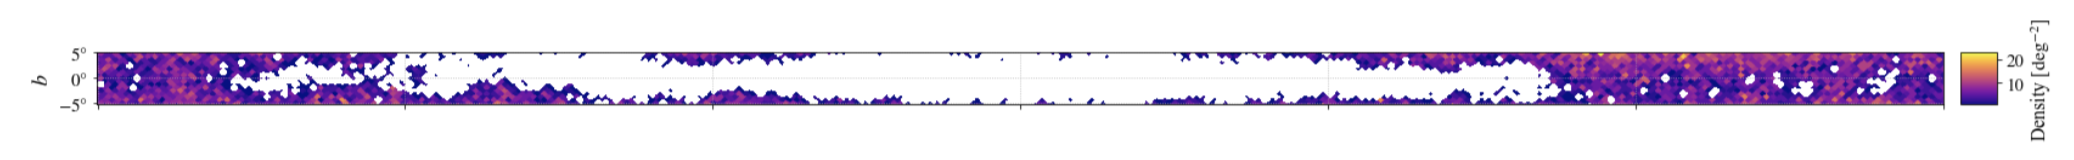


## dec > -30

In [11]:
df_declim = df[df.dec>-30]

<ipython-input-12-fe80f072dec1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_declim['pix'] = ahp.skycoord_to_healpix(coord)


The area per pix is 0.839 deg^2 and the highest density per pix is 126.297


80.00000000000003 99.99999999999997 -9.999999999999975 9.999999999999975


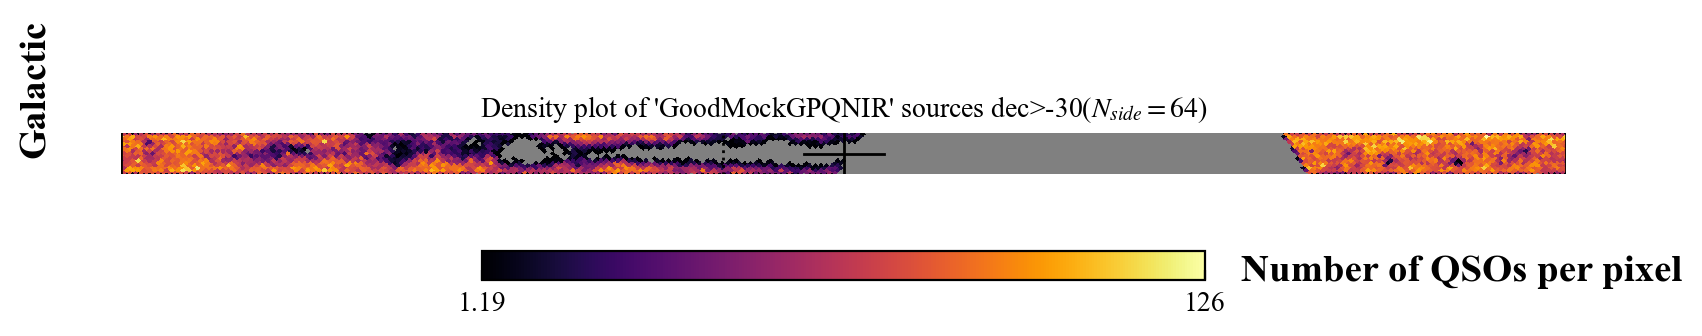

In [12]:
# coord = SkyCoord(ra=df['ra'].values * u.degree,
#                  dec=df['dec'].values * u.degree, frame='icrs')
# cgal = coord.transform_to(frame='galactic')

# nside	= 2**res	: The number of pixels per side.
# npix	= 12*nside**2	: The total number of pixels in the map.

nside = 64
coord = SkyCoord(l=df_declim['l'].values * u.degree,
                 b=df_declim['b'].values * u.degree, frame='galactic')
ahp = HEALPix(nside=nside, order='ring', frame=Galactic())
df_declim['pix'] = ahp.skycoord_to_healpix(coord)
hptb = df_declim.groupby('pix').size()
npix = hp.nside2npix(nside)

pi = np.pi
ssky = 4 * pi * ((180 / pi)**2)
spix = ssky / npix
sig_max = hptb.max() / (ssky / npix)
print('The area per pix is {0:.3f} deg^2 and the highest density per\
 pix is {1:.3f}'.format(spix, sig_max))

hpxmap = np.zeros(npix, dtype=float)
for i in hptb.index.values:
    hpxmap[i] = hptb[i]  # 只填充有值的位置
hpxmap = hpxmap/spix
hpxmap[hpxmap <= 0] = hp.pixelfunc.UNSEEN
# hpxmap_sm = hp.smoothing(hpxmap,fwhm=np.radians(1))

cartb = hp.cartview(hpxmap,
                    coord=["G"],
                    latra = [-5,5],  # 限制正负五度天区
                    cmap='inferno',
#             badcolor='w',
#             bgcolor='w',
                    unit="Number of QSOs per pixel",
                    xsize=1800, 
                    return_projected_map=True,
                   title="Density plot of 'GoodMockGPQNIR' sources dec>-30($N_{side}=64$)")

# aa = hp.cartview(ebv, 
#             latra=[-20,20],
#             cbar=False,
#             xsize=1800,
#             norm='log',
#             cmap='Accent',
#             return_projected_map=True)

map_dump = pd.DataFrame(cartb)
map_dump.to_csv('hpsm_MockGPQNIR_b5_bootstrap_dec>-30.csv',index=None)

hp.graticule()
f = plt.gcf()
# f.savefig('densMockGPQ.pdf')




iring = np.arange(npix)
inest = hp.ring2nest(nside, iring)
# hp.write_map('MockGPQ_healpixmap.fits',
#              m=[iring, inest, hpxmap],
#              coord='G',
#              column_names=['iring', 'inest', 'map'],
#              fits_IDL=False,
#              overwrite=True)

In [13]:
df_cmgpq_b5_b_declim = pd.read_csv('hpsm_MockGPQNIR_b5_bootstrap_dec>-30.csv',index_col=False)
cmgpq_b5_b_declim = df_cmgpq_b5_b_declim.values

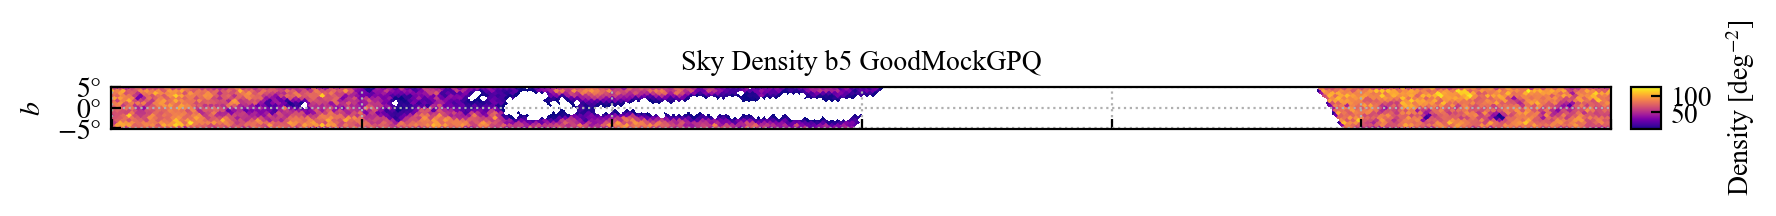

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, (ax1) = plt.subplots(nrows=1, figsize=(10,1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='2%', pad=0.1)
im = ax1.imshow(cmgpq_b5_b_declim.data,
                origin='lower',
                cmap='plasma',
#                 norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq))
               )
ax1.set_xticks(np.arange(0, 1801, 300))
ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                      r'$0\degree$',r'$300\degree$',r'$240\degree$',
                      r'$180\degree$'))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 51, 25))
ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax1.set_ylabel(r"$b$")
ax1.grid(linestyle=':')
cbar1 = fig.colorbar(im, cax=cax, 
                     orientation='vertical',
                     label='Density [$\mathrm{deg}^{-2}$]')
cbar1.ax.yaxis.label.set_size(10)
ax1.title.set_text('Sky Density b5 GoodMockGPQ')

# 3. plot other useful sky density (test)
## 最后的结果在mergecsvcounts
D_all, D_goodph  
用脚本遍历所有的gpc源来计算

In [3]:
from astropy.table import Table
import astropy.units as u
from matplotlib import mlab
from astropy.io import fits
from astropy.coordinates import SkyCoord
from pathlib import Path

## i) D_all (test set)

In [5]:
gpc_all = pd.read_csv('/cargo/public/catdata/gps-ps1-cat-coord/n64hp_all/n64pixhpSelCol_hgps-ps1-cat-0000.csv')

In [6]:
gpc_all

,n64pix
0,25229
1,25229
2,25229
3,25229
4,25229
...,...
849994,24234
849995,24234
849996,24234
849997,24234


In [16]:
# nside	= 2**res	: The number of pixels per side.
# npix	= 12*nside**2	: The total number of pixels in the map.

nside = 64

hptb = gpc_all.groupby('n64pix').size()
npix = hp.nside2npix(nside)

pi = np.pi
ssky = 4 * pi * ((180 / pi)**2)
spix = ssky / npix

In [25]:
hptb

n64pix
23201    118163
23456     54195
23457     26305
23713      1945
23963      8048
24219     62920
24233      9161
24234     33972
24475     65803
24489     89463
24973     31154
25229     95626
25230      2747
25346      4204
25485    142192
25523     33485
25601      1729
25602      4408
25780     56917
25858      7309
26035       253
dtype: int64

In [29]:
sig_min = hptb.min() / (ssky / npix)
sig_median = np.median(hptb) / (ssky / npix)
sig_max = hptb.max() / (ssky / npix)

print(sig_min)
print(sig_median)
print(sig_max)

301.4439599817833
37119.30881135366
169418.65437837836


In [27]:
print('The area per pix is {0:.3f} deg^2 and the highest density per\
 pix is {1:.3f}'.format(spix, sig_max))

The area per pix is 0.839 deg^2 and the highest density per pix is 169418.654


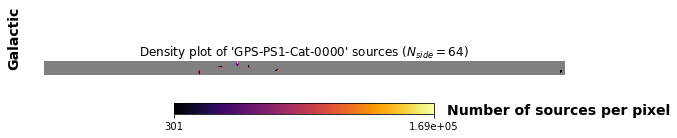

In [30]:
hpxmap = np.zeros(npix, dtype=float)
for i in hptb.index.values:
    hpxmap[i] = hptb[i]  # 只填充有值的位置
hpxmap = hpxmap/spix
hpxmap[hpxmap <= 0] = hp.pixelfunc.UNSEEN

cartb = hp.cartview(hpxmap,
                    coord=["G"],
                    latra = [-5,5],  # 限制正负五度天区
                    cmap='inferno',
                    unit="Number of sources per pixel",
                    xsize=1800, 
                    return_projected_map=True,
                   title="Density plot of 'GPS-PS1-Cat-0000' sources ($N_{side}=64$)")

80.00000000000003 99.99999999999997 -9.999999999999975 9.999999999999975


The area per pix is 0.839 deg^2 and the highest density per pix is 169419.846


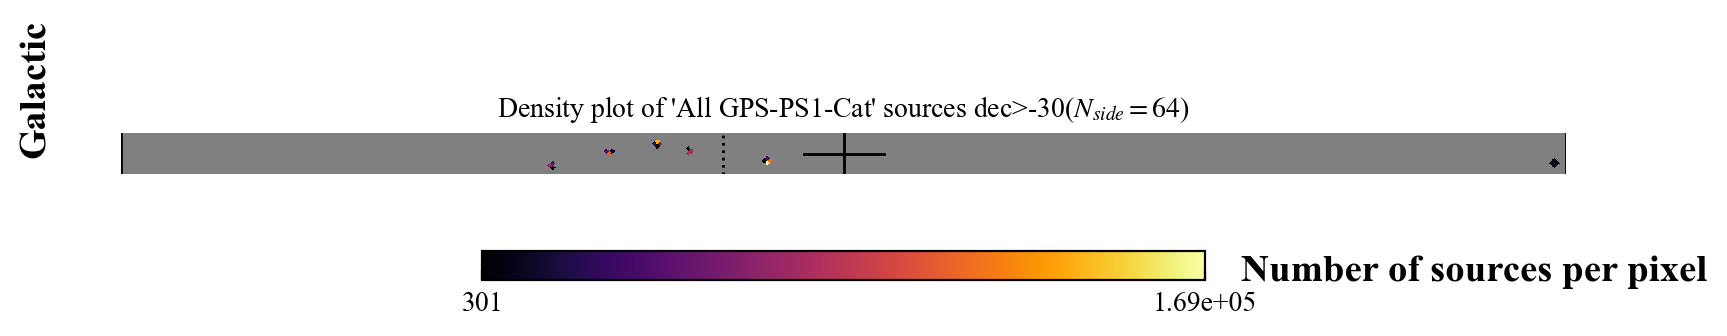

In [34]:
# coord = SkyCoord(ra=df['ra'].values * u.degree,
#                  dec=df['dec'].values * u.degree, frame='icrs')
# cgal = coord.transform_to(frame='galactic')

# nside	= 2**res	: The number of pixels per side.
# npix	= 12*nside**2	: The total number of pixels in the map.

nside = 64
coord = SkyCoord(l=gpc_sample_lite_declim['l'].values * u.degree,
                 b=gpc_sample_lite_declim['b'].values * u.degree, frame='galactic')
ahp = HEALPix(nside=nside, order='ring', frame=Galactic())
gpc_sample_lite_declim['pix'] = ahp.skycoord_to_healpix(coord)
hptb = gpc_sample_lite_declim.groupby('pix').size()
npix = hp.nside2npix(nside)

pi = np.pi
ssky = 4 * pi * ((180 / pi)**2)
spix = ssky / npix
sig_max = hptb.max() / (ssky / npix)
print('The area per pix is {0:.3f} deg^2 and the highest density per\
 pix is {1:.3f}'.format(spix, sig_max))

hpxmap = np.zeros(npix, dtype=float)
for i in hptb.index.values:
    hpxmap[i] = hptb[i]  # 只填充有值的位置
hpxmap = hpxmap/spix
hpxmap[hpxmap <= 0] = hp.pixelfunc.UNSEEN

cartb = hp.cartview(hpxmap,
                    coord=["G"],
                    latra = [-5,5],  # 限制正负五度天区
                    cmap='inferno',
                    unit="Number of sources per pixel",
                    xsize=1800, 
                    return_projected_map=True,
                   title="Density plot of 'All GPS-PS1-Cat' sources dec>-30($N_{side}=64$)")



map_dump = pd.DataFrame(cartb)
map_dump.to_csv('hpsm_All_gpc_b5_dec>-30.csv',index=None)

hp.graticule()
f = plt.gcf()

iring = np.arange(npix)
inest = hp.ring2nest(nside, iring)


In [35]:
df_cmall_b5_b_declim = pd.read_csv('hpsm_All_gpc_b5_dec>-30.csv',index_col=False)
cmall_b5_b_declim = df_cmall_b5_b_declim.values

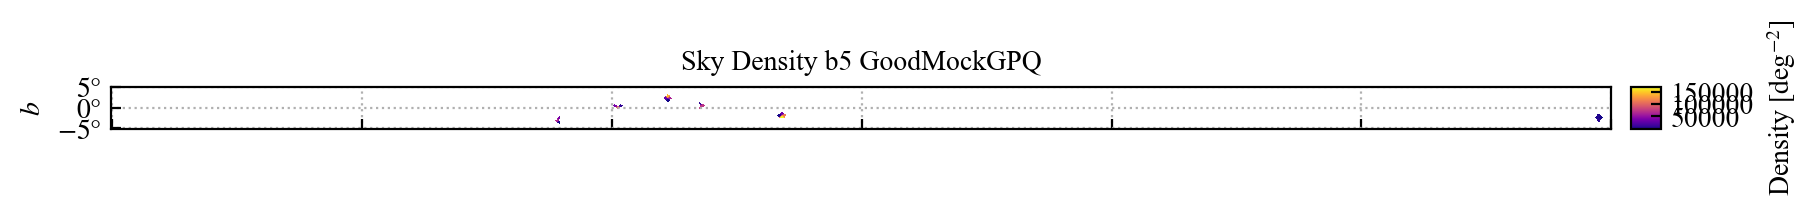

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
fig, (ax1) = plt.subplots(nrows=1, figsize=(10,1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='2%', pad=0.1)
im = ax1.imshow(cmall_b5_b_declim.data,
                origin='lower',
                cmap='plasma',
#                 norm=mpl.colors.Normalize(vmin=0, vmax=np.nanmax(cmgpq))
               )
ax1.set_xticks(np.arange(0, 1801, 300))
ax1.set_xticklabels((r'$180\degree$',r'$120\degree$',r'$60\degree$',
                      r'$0\degree$',r'$300\degree$',r'$240\degree$',
                      r'$180\degree$'))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0, 51, 25))
ax1.set_yticklabels((r'$-5\degree$',r'$0\degree$',r'$5\degree$'))
ax1.set_ylabel(r"$b$")
ax1.grid(linestyle=':')
cbar1 = fig.colorbar(im, cax=cax, 
                     orientation='vertical',
                     label='Density [$\mathrm{deg}^{-2}$]')
cbar1.ax.yaxis.label.set_size(10)
ax1.title.set_text('Sky Density b5 GPQ')